In [1]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
import torch
import scipy as sp
import json
import numpy as np
from glob import glob
import anndata
import pandas as pd
from src.single_vae import VAE
from src.multi_vae import CrossSpeciesVAE
from src.callbacks import StageAwareEarlyStopping
from src.data import CrossSpeciesDataModule
import pickle
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score
import scanpy as sc
import matplotlib.pyplot as plt
import umap
import hnswlib

def _tanh_scale(x,scale=10,center=0.5):
    return center + (1-center) * np.tanh(scale * (x - center))

def _united_proj(wpca1, wpca2, k=20, metric="cosine", ef=200, M=48):

    metric = 'l2' if metric == 'euclidean' else metric
    metric = 'cosine' if metric == 'correlation' else metric
    labels2 = np.arange(wpca2.shape[0])
    p2 = hnswlib.Index(space=metric, dim=wpca2.shape[1])
    p2.init_index(max_elements=wpca2.shape[0], ef_construction=ef, M=M)
    p2.add_items(wpca2, labels2)
    p2.set_ef(ef)
    idx1, dist1 = p2.knn_query(wpca1, k=k)

    if metric == 'cosine':
        dist1 = 1 - dist1
        dist1[dist1 < 1e-3] = 1e-3
        dist1 = dist1/dist1.max(1)[:,None]
        dist1 = _tanh_scale(dist1,scale=10, center=0.7)
    else:
        sigma1 = dist1[:,4]
        sigma1[sigma1<1e-3]=1e-3
        dist1 = np.exp(-dist1/sigma1[:,None])
        
    Sim1 = dist1  # np.exp(-1*(1-dist1)**2)
    knn1v2 = sp.sparse.lil_matrix((wpca1.shape[0], wpca2.shape[0]))
    x1 = np.tile(np.arange(idx1.shape[0])[:, None], (1, idx1.shape[1])).flatten()
    knn1v2[x1.astype('int32'), idx1.flatten().astype('int32')] = Sim1.flatten()
    return knn1v2.tocsr()

from pynndescent import NNDescent

def find_nearest_neighbors(L1, L2, n_neighbors=15, metric='correlation'):
    """
    Finds the nearest neighbors from L1 (query) to L2 (index) using pynndescent.

    Parameters:
        L1 (np.ndarray): Query embeddings of shape (num_queries, embedding_dim).
        L2 (np.ndarray): Index embeddings of shape (num_index, embedding_dim).
        n_neighbors (int): Number of neighbors to find. Default is 5.
        metric (str): Distance metric to use. Default is 'euclidean'.

    Returns:
        indices (np.ndarray): Indices of nearest neighbors in L2 for each query in L1.
        distances (np.ndarray): Distances to nearest neighbors for each query in L1.
    """
    # Validate inputs
    if not isinstance(L1, np.ndarray) or not isinstance(L2, np.ndarray):
        raise ValueError("L1 and L2 must be numpy arrays.")
    
    if L1.shape[1] != L2.shape[1]:
        raise ValueError("L1 and L2 must have the same embedding dimension.")

    # Build the index on L2
    index = NNDescent(L2, metric=metric, n_neighbors=n_neighbors)
    
    # Query the nearest neighbors for L1
    indices, distances = index.query(L1, k=n_neighbors)
    
    return indices, distances

In [2]:
species_data_sub = pickle.load(open('data.p','rb'))

adata1 = species_data_sub['wagner']
adata2 = species_data_sub['briggs']

batch_size = 256

data_module = CrossSpeciesDataModule(
    species_data = species_data_sub,
    batch_size=batch_size,
    num_workers=0,
    val_split=0.1,
    test_split=0.1,
    yield_pairwise=False,
)
data_module.setup()

species_vocab_sizes = data_module.species_vocab_sizes
homology_edges, homology_scores = pickle.load(open('homology_zfxe.p','rb'))


early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=True,
    mode='min'
)



model = CrossSpeciesVAE(
    species_vocab_sizes=species_vocab_sizes,
    homology_edges=homology_edges,
    homology_scores=homology_scores,
    batch_size=batch_size,
    
    # Loss weights
    direct_recon_weight=1.0,
    cross_species_recon_weight=1.0,
    
    # Learning rate
    base_learning_rate=5e-3,
    min_learning_rate=5e-5,    
    warmup_data=0.1,
    
    # Homology dropout
    homology_dropout_rate=0.1,
    
    # Testing
    use_gene_importance=False,
)

# Initialize the trainer
trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    max_epochs=20,
    precision='16-mixed',
    gradient_clip_val=model.gradient_clip_val,
    gradient_clip_algorithm="norm",
    log_every_n_steps=1,
    deterministic=True,
    callbacks=[early_stopping],
    accumulate_grad_batches=1,
    enable_progress_bar=True,
    fast_dev_run=False,
    logger=CSVLogger(
        save_dir="logs",
        name="metrics",
        flush_logs_every_n_steps=10
    )    
)


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [3]:
trainer.fit(model, data_module)
print(trainer.current_epoch)

You are using a CUDA device ('NVIDIA H100 80GB HBM3') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.
/opt/jupyter-envs/generate-cross-species/atar-vscode/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/opt/jupyter-envs/generate-cross-species/atar-vscode/conda/lib/python3.11/site-packages/pytorch_lightning/utilities/data.py:122: Your `IterableDataset` has `__len__` defined. In 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/jupyter-envs/generate-cross-species/atar-vscode/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.830


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.037 >= min_delta = 0.001. New best score: 0.793


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.025 >= min_delta = 0.001. New best score: 0.768


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.014 >= min_delta = 0.001. New best score: 0.754


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.014 >= min_delta = 0.001. New best score: 0.739


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.731


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.727


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.724


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.722


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.721


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.718


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.716


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.715


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


20


Species 1 0.24298889445660443
Species 2 0.28442171367011426
Cross species 0.23364474916954783
Cross species 1 0.28385170480751115
Cross species 2 0.20477720355062995


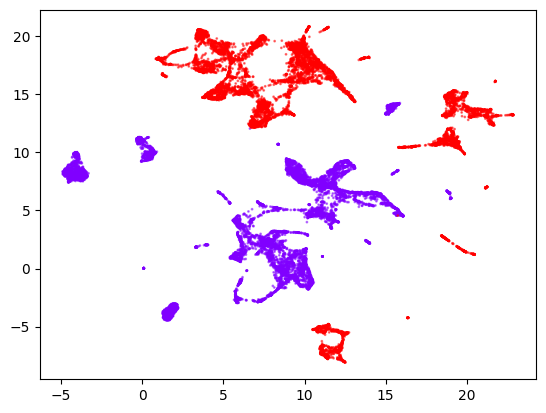

In [4]:
output, s = model.get_latent_embeddings(species_data_sub, batch_size=4096)
latent = output.cpu().numpy()
s=s.cpu().numpy()

#output, s = model.get_latent_embeddings(species_data)
#s=s.cpu().numpy()

#plt.figure();
#dt_full = umap.UMAP(n_components=2).fit_transform(output.detach().cpu().numpy())
#plt.scatter(dt_full[:,0],dt_full[:,1], c = s,s=5, cmap='rainbow'); plt.colorbar()

for i, adata, key in zip([0, 1], [species_data_sub['wagner'], species_data_sub['briggs']], ['cell_type', 'cell_type']):
    # dt = dt_full[s==i] # umap.UMAP(n_components=2).fit_transform(output[s==i].detach().cpu().numpy())

    adata.obsm['emb'] = latent[s==i]
    sc.pp.neighbors(adata, use_rep='emb')
    sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution=2)
    print(f"Species {i+1}", adjusted_rand_score(adata.obs[key], adata.obs['leiden']))
    
#     plt.figure();
#     plt.scatter(dt[:,0],dt[:,1], c = adata.obs[key].cat.codes,s=5, cmap='rainbow'); plt.colorbar()
    
adatas = []
for i, k in enumerate(species_data_sub):
    adata = species_data_sub[k]
    adata.obsm['emb'] = latent[s==i]
    adata.obs['species'] = k
    adatas.append(adata)

adata = anndata.concat(adatas,join='outer')

nnm1v2 = _united_proj(latent[s==0],latent[s==1], k=15, metric='cosine')
nnm2v1 = _united_proj(latent[s==1],latent[s==0], k=15, metric='cosine')

sc.pp.neighbors(adata, use_rep='emb')
adata.obsp['connectivities'] = sp.sparse.vstack((sp.sparse.hstack((sp.sparse.csr_matrix((nnm1v2.shape[0],nnm1v2.shape[0])), nnm1v2)),
sp.sparse.hstack((nnm2v1, sp.sparse.csr_matrix((nnm2v1.shape[0],nnm2v1.shape[0]))))))
sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution=2)
print("Cross species", adjusted_rand_score(adata.obs['cell_type'], adata.obs['leiden']))

x,y = nnm1v2.nonzero()
cl1 = np.array(list(adata1.obs['cell_type']))
cl2 = np.array(list(adata2.obs['cell_type']))

a = cl2[y.reshape((nnm1v2.shape[0], 15))]
cl1_new = []
for i in range(a.shape[0]):
    b,v = np.unique(a[i],return_counts=True)
    cl1_new.append(b[np.argmax(v)])

cl1_new = np.array(cl1_new)

print("Cross species 1", adjusted_rand_score(adata1.obs['cell_type'], cl1_new))

x,y = nnm2v1.nonzero()

a = cl1[y.reshape((nnm2v1.shape[0], 15))]
cl2_new = []
for i in range(a.shape[0]):
    b,v = np.unique(a[i],return_counts=True)
    cl2_new.append(b[np.argmax(v)])

cl2_new = np.array(cl2_new)

print("Cross species 2", adjusted_rand_score(adata2.obs['cell_type'], cl2_new))

plt.figure();
dt_full = umap.UMAP(n_components=2).fit_transform(output.detach().cpu().numpy())
plt.scatter(dt_full[:,0],dt_full[:,1],c=s,s=1, alpha=0.5, cmap='rainbow');

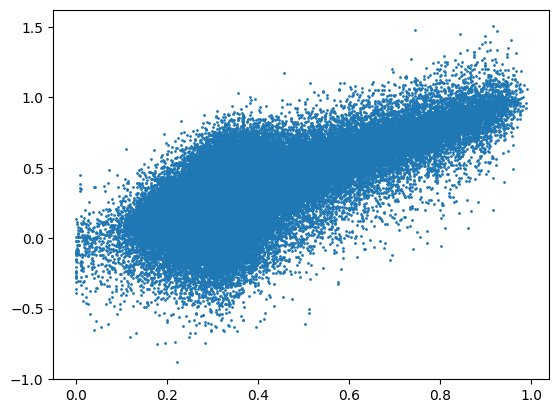

In [5]:
plt.figure(); plt.scatter(homology_scores[0][1], model.scores_0_1.detach().cpu().numpy(), s=1)

In [6]:
import numpy as np
import plotly.io as pio
pio.renderers.default = "notebook"



import plotly.graph_objects as go
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import plotly.io as pio
pio.renderers.default = 'notebook'
def create_sankey_from_similarity(
    similarity_matrix: np.ndarray,
    source_labels: list,
    target_labels: list,
    threshold: float = 0.1,
    title: str = "Cross-species Label Similarity",
    width: int = 1000,
    height: int = 800
) -> go.Figure:
    """
    Create a Sankey diagram from a bipartite similarity matrix with weighted edges.
    """
    # Create node labels
    labels = source_labels + target_labels
    
    # Create source, target, and value arrays for links
    sources = []
    targets = []
    values = []
    
    # Create hover text for links
    link_labels = []
    
    # Iterate through similarity matrix
    for i in range(similarity_matrix.shape[0]):
        for j in range(similarity_matrix.shape[1]):
            if similarity_matrix[i,j] > threshold:
                sources.append(i)
                targets.append(j + len(source_labels))
                values.append(similarity_matrix[i,j])
                link_labels.append(f"{source_labels[i]} → {target_labels[j]}: {similarity_matrix[i,j]:.3f}")
    
    # Normalize values to make them more visually appealing
    values = np.array(values)
    values = values / values.max() * 100  # Scale to 0-100 range for better visualization
    
    # Create color arrays for nodes
    node_colors = ['#1f77b4'] * len(source_labels) + ['#ff7f0e'] * len(target_labels)
    
    # Create Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        node = dict(
            pad = 15,
            thickness = 20,
            line = dict(color = "black", width = 0.5),
            label = labels,
            color = node_colors
        ),
        link = dict(
            source = sources,
            target = targets,
            value = values,
            customdata = link_labels,
            color = ['rgba(31, 119, 180, 0.4)'] * len(sources),  # Semi-transparent links
            hovertemplate = '%{customdata}<extra></extra>'
        )
    )])
    
    # Update layout
    fig.update_layout(
        title_text=title,
        font_size=12,
        width=width,
        height=height,
        showlegend=False,
        margin=dict(t=40, l=40, r=40, b=40)
    )
    
    # Display in notebook
    # fig.show(renderer="notebook")
    return fig

def format_cross_species_similarities(
    similarity_matrix: np.ndarray,
    source_labels: np.ndarray,
    target_labels: np.ndarray,
    source_species: str = "wagner",
    target_species: str = "briggs",
    top_n: int | None = None
) -> pd.DataFrame:
    """
    Format similarity matrix into a DataFrame with columns for each species-cell type combination.
    
    Args:
        similarity_matrix: NxM matrix of similarities
        source_labels: N labels from source species
        target_labels: M labels from target species
        source_species: Name of source species
        target_species: Name of target species
        top_n: Optional number of top matches to include (None for all)
    """
    # Create columns for both species
    columns = pd.MultiIndex.from_tuples(
        # Wagner columns
        [(source_species, cell_type, col_name)
         for cell_type in source_labels
         for col_name in ['matched_type', 'similarity']] +
        # Briggs columns
        [(target_species, cell_type, col_name)
         for cell_type in target_labels
         for col_name in ['matched_type', 'similarity']]
    )
    
    # Initialize DataFrame
    max_rows = max(
        len(target_labels) if top_n is None else top_n,
        len(source_labels) if top_n is None else top_n
    )
    df = pd.DataFrame(index=range(max_rows), columns=columns)
    
    # Fill Wagner -> Briggs mappings
    for i, source_label in enumerate(source_labels):
        similarities = similarity_matrix[i]
        sorted_indices = np.argsort(similarities)[::-1]
        if top_n is not None:
            sorted_indices = sorted_indices[:top_n]
            
        df[(source_species, source_label, 'matched_type')] = target_labels[sorted_indices]
        df[(source_species, source_label, 'similarity')] = similarities[sorted_indices]
    
    # Fill Briggs -> Wagner mappings (using transposed similarity matrix)
    similarity_matrix_T = similarity_matrix.T
    for i, target_label in enumerate(target_labels):
        similarities = similarity_matrix_T[i]
        sorted_indices = np.argsort(similarities)[::-1]
        if top_n is not None:
            sorted_indices = sorted_indices[:top_n]
            
        df[(target_species, target_label, 'matched_type')] = source_labels[sorted_indices]
        df[(target_species, target_label, 'similarity')] = similarities[sorted_indices]
    
    return df


def generate_label_similarity_matrix(latent, s, i, j, name1, name2, K):
    nnm = _united_proj(latent[s==j],latent[s==i], k=K, metric='cosine')
    x, y = nnm.nonzero()
    indices_x = x.reshape((nnm.shape[0],K))
    indices_y = y.reshape((nnm.shape[0],K))
    similarities = nnm.data.reshape((nnm.shape[0],K))


    cl1 = np.array(list(species_data_sub['wagner'].obs[name1]))
    cl2 = np.array(list(species_data_sub['briggs'].obs[name2]))

    clu1,cluc1 = np.unique(cl1, return_counts=True)
    clu2,cluc2 = np.unique(cl2, return_counts=True)

    C = np.zeros((clu1.size,clu2.size))


    df = pd.DataFrame();
    df['labels_0'] = cl1[indices_y].flatten()
    df['labels_1'] = cl2[indices_x].flatten()
    df['similarities'] = similarities.flatten()
    df = df.groupby(['labels_0','labels_1']).sum().reset_index()

    C[pd.Series(index=clu1,data=np.arange(clu1.size))[df['labels_0']].values, pd.Series(index=clu2,data=np.arange(clu2.size))[df['labels_1']].values] = df['similarities'].values
    C = np.stack((C / cluc1[:,None], C/cluc2[None,:]),axis=2).min(2)
    
    return C, clu1, clu2



In [7]:
K = 50
latent = output.cpu().numpy()

C1, clu1_1, clu1_2 = generate_label_similarity_matrix(latent, s, 0, 1, 'TimeID', 'Developmental_stage', 50)
C2, clu2_1, clu2_2 = generate_label_similarity_matrix(latent, s, 0, 1, 'cell_type', 'cell_type', 50)

In [8]:
pd.set_option('display.max_columns', None)

# Create the DataFrame with top 5 matches
similarity_df1 = format_cross_species_similarities(C1, clu1_1, clu1_2, top_n=5)
similarity_df2 = format_cross_species_similarities(C2, clu2_1, clu2_2, top_n=5)

In [9]:
similarity_df1['briggs']

Stage_10                Stage_11                Stage_12             \
  matched_type similarity matched_type similarity matched_type similarity   
0        18hpf   7.357427        18hpf  17.968542         4hpf  18.578582   
1        24hpf   2.546233         4hpf   8.729162        24hpf   4.229627   
2        14hpf   0.424165        24hpf   5.022000         6hpf   2.900277   
3         4hpf   0.346050         6hpf   0.000000        18hpf   1.995338   
4        10hpf   0.004214         8hpf   0.000000        14hpf   0.203665   

      Stage_13                Stage_14                Stage_16             \
  matched_type similarity matched_type similarity matched_type similarity   
0         4hpf  20.251518         4hpf  17.433680         4hpf  22.013943   
1        24hpf   3.426173         6hpf   7.250319         6hpf   3.390929   
2        18hpf   1.164499        24hpf   2.441198        24hpf   2.765817   
3        14hpf   0.023544        18hpf   1.044147        10hpf   2.267451   
4         6hpf   0.022762        14hpf   0.207750        14hpf   1.535326   

      Stage_18                Stage_20                Stage_22             \
  matched_type similarity matched_type similarity matched_type similarity   
0         4hpf  24.103789         4hpf  28.208108         4hpf  32.976318   
1         6hpf   3.043612        24hpf   2.639100        24hpf   4.760813   
2        24hpf   2.374408         6hpf   1.756880         6hpf   1.352237   
3        18hpf   1.528199        18hpf   1.475529        18hpf   1.138610   
4        10hpf   0.932305        10hpf   0.838642        10hpf   0.532533   

       Stage_8             
  matched_type similarity  
0        18hpf   2.108000  
1        24hpf   0.446064  
2        14hpf   0.040758  
3         4hpf   0.000000  
4         6hpf   0.000000

In [10]:
similarity_df2['briggs']

Blastula                          Blood             \
             matched_type similarity        matched_type similarity   
0                   Optic   4.993848         pluripotent  10.822116   
1      Forebrain/midbrain   0.731574      Eye primordium   0.153357   
2  Neural crest - crestin   0.539226  Forebrain/midbrain   0.100968   
3                    Lens   0.466323             Tailbud   0.076839   
4               Hindbrain   0.313362           Hindbrain   0.052159   

    Cement gland primordium                       Endoderm             \
               matched_type similarity        matched_type similarity   
0               pluripotent   2.594200              Neuron   5.004594   
1  Involuting marginal zone   0.789546         pluripotent   3.336398   
2             Neuroectoderm   0.556855  Forebrain/midbrain   1.362947   
3       Non-neural ectoderm   0.355446           Hindbrain   0.855658   
4                  Endoderm   0.332394               Optic   0.553889   

            Endothelial                 Epidermal progenitor             \
           matched_type similarity              matched_type similarity   
0           pluripotent   5.134678               pluripotent  26.656957   
1           Endothelial   0.426286  Involuting marginal zone   2.792601   
2                Neuron   0.311605             Neuroectoderm   2.790313   
3  Neural crest - mcamb   0.260678        Forebrain/midbrain   2.530875   
4                 Optic   0.194769                 Hindbrain   2.268869   

               Eye primordium                     Forebrain/midbrain  \
                 matched_type similarity                matched_type   
0                 Endothelial  15.092147                 Endothelial   
1                  Macrophage   9.342219  Neural crest - xanthophore   
2  Neural crest - xanthophore   6.088769                  Macrophage   
3                 pluripotent   3.511205                 pluripotent   
4  Neural crest - melanoblast   1.140612  Neural crest - melanoblast   

                                Germline                          Goblet cell  \
  similarity                matched_type similarity              matched_type   
0   8.454262                  Macrophage   0.654153               pluripotent   
1   8.225566  Neural crest - xanthophore   0.540676             Neuroectoderm   
2   8.195094                 pluripotent   0.232745  Involuting marginal zone   
3   3.231756   Neural crest - iridoblast   0.163170       Non-neural ectoderm   
4   2.293708      Neural crest - crestin   0.108543            Eye primordium   

                  Hatching gland                            Heart             \
  similarity        matched_type similarity          matched_type similarity   
0  10.971930      Eye primordium   0.787928           pluripotent   0.663101   
1   0.365364         pluripotent   0.733818  Neural crest - mcamb   0.127842   
2   0.238238       Neuroectoderm   0.076418              Germline   0.098121   
3   0.226914      Apoptotic-like   0.076374                 Optic   0.016845   
4   0.219025  Forebrain/midbrain   0.076155               Tailbud   0.016494   

                    Hindbrain             Intermediate mesoderm             \
                 matched_type similarity           matched_type similarity   
0                  Macrophage  13.915998            pluripotent  36.167434   
1                 pluripotent  11.782602                 Neuron   1.652512   
2                 Endothelial  11.194324        Skeletal muscle   1.135589   
3  Neural crest - xanthophore   5.390564     Forebrain/midbrain   0.967359   
4                       Blood   1.461903  Intermediate mesoderm   0.778667   

     Involuting marginal zone                               Ionocyte  \
                 matched_type similarity                matched_type   
0                      Neuron   7.463638                 pluripotent   
1  Neural crest - xanthophore   3.802382  Neural crest - xanthophore   
2           

0.3453044425431827


In [ ]:
similarity_df['wagner']

In [34]:
from src.single_vae import VAE

# homology_edges, homology_scores = pickle.load(open('homology_zfxe.p','rb'))
# # Loading
# checkpoint = torch.load('model_checkpoint.pt')
# model = CrossSpeciesVAE(
#     homology_edges=homology_edges,
#     homology_scores=homology_scores,
#     **checkpoint['hyper_parameters']
# )
# model.load_state_dict(checkpoint['state_dict'])
# model.eval();  # if using for inference

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0,
    patience=3,
    verbose=True,
    mode='min'
)

# Initialize the trainer
trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    max_epochs=10,
    precision='16-mixed',
    gradient_clip_val=model.gradient_clip_val,
    gradient_clip_algorithm="norm",
    log_every_n_steps=1,
    deterministic=True,
    callbacks=[early_stopping],
    accumulate_grad_batches=1,
    enable_progress_bar=True,
    fast_dev_run=False,
    logger=CSVLogger(
        save_dir="logs",
        name="metrics",
        flush_logs_every_n_steps=10
    )    
)

scvi = VAE(
    cross_species_vae = model,
    n_latent = 256,
    hidden_dims = [256],

    batch_size = batch_size,
    base_batch_size = 256,
    
    base_learning_rate = 1e-3,    
    min_learning_rate = 1e-5,
    warmup_data = 0.1,
    
    init_beta = 1e-3,
    final_beta = 1.0,
    
    gradient_clip_val = 1.0,
    gradient_clip_algorithm = "norm",  
    
    deeply_inject_species=False,
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [35]:
trainer.fit(scvi, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.
/opt/jupyter-envs/generate-cross-species/atar-vscode/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.

/opt/jupyter-envs/generate-cross-species/atar-vscode/conda/lib/python3.11/site-packages/pytorch_lightning/utilities/data.py:122: UserWarning:

Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


  | Name              | Type            | Params | Mode 
--------------------------------------------------------------
0 | cross_species_vae | Cr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/jupyter-envs/generate-cross-species/atar-vscode/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.



Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.450


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 0.403


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.387


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.384


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.383


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 3 records. Best score: 0.383. Signaling Trainer to stop.


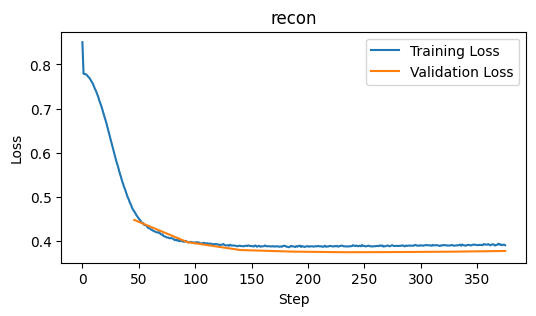

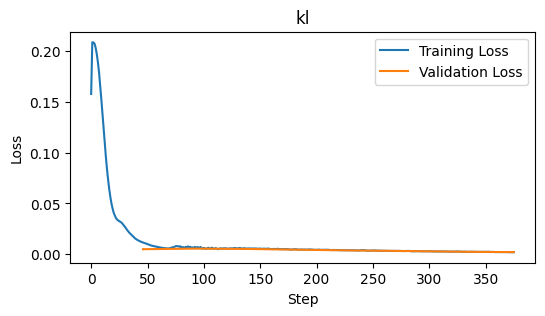

In [36]:
,# Load the latest version
version = max([int(d.split('_')[-1]) for d in glob('logs/metrics/version_*')])
df = pd.read_csv(f'logs/metrics/version_{version}/metrics.csv')


for loss_type in ["recon", "kl"]:
    # Get specific metrics
    train_loss = df[f'train_{loss_type}'][df[f'train_{loss_type}'] != 0.0]
    train_step = df['step'][df[f'train_{loss_type}'] != 0.0]
    f1 = ~train_loss.isna()
    val_loss =  df[f'val_{loss_type}']#[df[f'val_{loss_type}'] != 0.0]
    val_step = df['step']#[df[f'val_{loss_type}'] != 0.0]    
    f2 = ~val_loss.isna()

    # Plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6, 3))
    plt.plot(train_step[f1], train_loss[f1], label='Training Loss')
    plt.plot(val_step[f2], val_loss[f2], label='Validation Loss')

    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title(loss_type)
    plt.legend()

In [37]:
output,s = scvi.get_latent_embeddings(species_data_sub, batch_size=4096)
s=s.cpu().numpy()


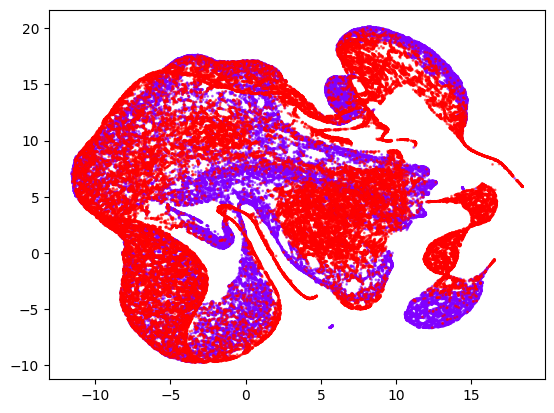

In [38]:
plt.figure();
dt_full = umap.UMAP(n_components=2).fit_transform(output.detach().cpu().numpy())
plt.scatter(dt_full[:,0],dt_full[:,1],c=s,s=1, alpha=0.5, cmap='rainbow');

0.397577899283943
0.361115285788397


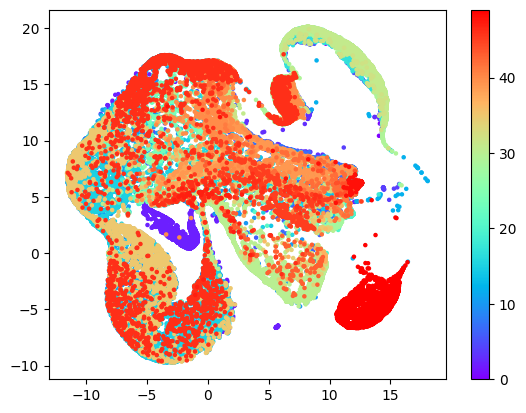

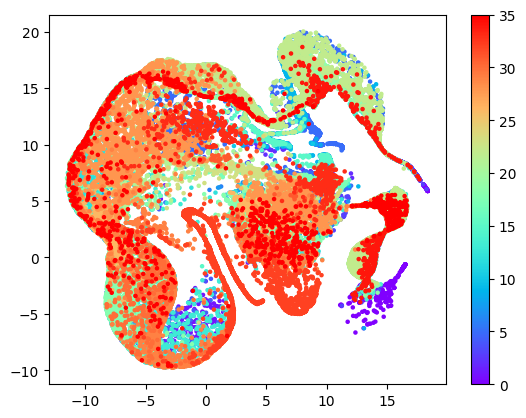

In [39]:
for i, adata, key in zip([0, 1], [species_data_sub['wagner'], species_data_sub['briggs']], ['cell_type', 'cell_type']):
    dt = dt_full[s==i]

    adata.obsm['emb'] = dt
    sc.pp.neighbors(adata, use_rep='emb')
    sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution=2)
    print(adjusted_mutual_info_score(adata.obs[key], adata.obs['leiden']))
    
    plt.figure();
    plt.scatter(dt[:,0],dt[:,1], c = adata.obs[key].cat.codes,s=5, cmap='rainbow'); plt.colorbar()
    

In [15]:
latent = output.cpu().numpy()
adatas = []
for i, k in enumerate(species_data_sub):
    adata = species_data_sub[k]
    adata.obsm['emb'] = latent[s==i]
    adata.obs['species'] = k
    adatas.append(adata)

adata = anndata.concat(adatas,join='outer')
adata.obsm['X_umap'] = dt_full

import scanpy as sc

sc.external.pp.harmony_integrate(adata, "species", basis='emb', adjusted_basis='X_pca_harmony')

adata.obsm['X_umap'] = umap.UMAP().fit_transform(adata.obsm['X_pca_harmony'])

2024-12-14 00:12:39,858 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-12-14 00:12:41,325 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-12-14 00:12:41,369 - harmonypy - INFO - Iteration 1 of 10
2024-12-14 00:12:45,205 - harmonypy - INFO - Iteration 2 of 10
2024-12-14 00:12:48,989 - harmonypy - INFO - Iteration 3 of 10
2024-12-14 00:12:52,744 - harmonypy - INFO - Iteration 4 of 10
2024-12-14 00:12:56,527 - harmonypy - INFO - Iteration 5 of 10
2024-12-14 00:13:00,196 - harmonypy - INFO - Iteration 6 of 10
2024-12-14 00:13:02,641 - harmonypy - INFO - Iteration 7 of 10
2024-12-14 00:13:04,693 - harmonypy - INFO - Iteration 8 of 10
2024-12-14 00:13:06,892 - harmonypy - INFO - Iteration 9 of 10
2024-12-14 00:13:08,816 - harmonypy - INFO - Iteration 10 of 10
2024-12-14 00:13:10,871 - harmonypy - INFO - Converged after 10 iterations


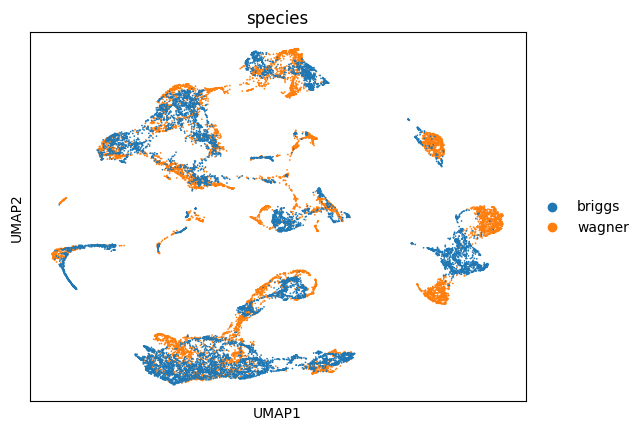

In [16]:
sc.pl.umap(adata,color='species')

In [17]:
K = 50
latent = adata.obsm['X_pca_harmony']

nnm = _united_proj(latent[s==1],latent[s==0], k=K, metric='cosine')
x, y = nnm.nonzero()
indices_x = x.reshape((nnm.shape[0],K))
indices_y = y.reshape((nnm.shape[0],K))
similarities = nnm.data.reshape((nnm.shape[0],K))


cl1 = np.array(list(species_data_sub['wagner'].obs['cell_type']))
cl2 = np.array(list(species_data_sub['briggs'].obs['cell_type']))

clu1,cluc1 = np.unique(cl1, return_counts=True)
clu2,cluc2 = np.unique(cl2, return_counts=True)

C = np.zeros((clu1.size,clu2.size))


df = pd.DataFrame();
df['labels_0'] = cl1[indices_y].flatten()
df['labels_1'] = cl2[indices_x].flatten()
df['similarities'] = similarities.flatten()
df = df.groupby(['labels_0','labels_1']).sum().reset_index()

C[pd.Series(index=clu1,data=np.arange(clu1.size))[df['labels_0']].values, pd.Series(index=clu2,data=np.arange(clu2.size))[df['labels_1']].values] = df['similarities'].values
C = np.stack((C / cluc1[:,None], C/cluc2[None,:]),axis=2).min(2)


In [18]:
similarity_df = format_cross_species_similarities(C, clu1, clu2, top_n=10)

In [19]:
similarity_df['briggs']

Blastula                          Blood             \
              matched_type similarity        matched_type similarity   
0                 Endoderm   3.575150               Optic   4.526556   
1      Presomitic mesoderm   2.301391  Forebrain/midbrain   1.665320   
2  Rare epidermal subtypes   1.880021           Hindbrain   1.575716   
3      Non-neural ectoderm   1.580697        Neural crest   0.370278   
4    Intermediate mesoderm   1.468018             Tailbud   0.237750   
5                  Tailbud   1.143198               Heart   0.212100   
6         Dorsal organizer   1.130175                Lens   0.056131   
7                 Germline   0.976103            Endoderm   0.043676   
8             Neural crest   0.825734  Rohon-beard neuron   0.031152   
9                    Heart   0.796415   Olfactory placode   0.018620   

   Cement gland primordium                             Endoderm             \
              matched_type similarity              matched_type similarity   
0     Epidermal progenitor   5.566423  Involuting marginal zone   3.549161   
1            Placodal area   1.974336                  Endoderm   3.104826   
2              Endothelial   1.722419          Dorsal organizer   2.773489   
3  Rare epidermal subtypes   0.798470     Intermediate mesoderm   2.182292   
4   Neural crest - crestin   0.545541              Neural crest   2.135392   
5                    Heart   0.498838       Presomitic mesoderm   1.860331   
6    Intermediate mesoderm   0.475478       Non-neural ectoderm   1.779196   
7                      NaN   0.436580                   Tailbud   1.564154   
8         Pharyngeal pouch   0.405387             Neuroectoderm   1.536026   
9             Otic placode   0.358465                     Heart   1.417260   

            Endothelial                 Epidermal progenitor             \
           matched_type similarity              matched_type similarity   
0                 Optic   2.203406      Epidermal progenitor  12.061454   
1          Neural crest   1.271730     Intermediate mesoderm   8.635573   
2    Forebrain/midbrain   1.129656               pluripotent   8.318399   
3             Hindbrain   0.771604             Neuroectoderm   1.679391   
4                 Heart   0.640465  Involuting marginal zone   1.652851   
5               Tailbud   0.268082             Placodal area   1.650957   
6                  Lens   0.102879                  periderm   1.486540   
7    Rohon-beard neuron   0.102857                  Endoderm   1.342475   
8  Neural crest - mcamb   0.082310   Rare epidermal subtypes   1.315267   
9              Endoderm   0.064136                    Neuron   1.280491   

          Eye primordium                Forebrain/midbrain             \
            matched_type similarity           matched_type similarity   
0              Hindbrain   3.640943              Hindbrain   3.031546   
1     Forebrain/midbrain   2.432176     Forebrain/midbrain   2.052431   
2                 Neuron   0.778933                Tailbud   1.261222   
3                Tailbud   0.772233                 Neuron   0.229787   
4                  Optic   0.398815           Neural crest   0.160965   
5           Neural crest   0.170133                  Optic   0.150223   
6   Epidermal progenitor   0.131762                  Heart   0.088701   
7                  Heart   0.124126    Presomitic mesoderm   0.061660   
8  Intermediate mesoderm   0.109674  Intermediate mesoderm   0.052845   
9    Presomitic mesoderm   0.080908   Neural crest - mcamb   0.049897   

             Germline                         Goblet cell             \
         matched_type similarity             matched_type similarity   
0    Dorsal organizer   0.539338     Epidermal progenitor  13.493476   
1              Neuron   0.146332            Placodal area   4.053374   
2            Germline   0.124720              Endothelial   3.534064   
3      Apoptotic-like   0.076797                Notochord   2.375823   
4     

In [30]:
similarity_df['wagner']

Apoptotic-like                    Apoptotic-like 2             \
               matched_type similarity             matched_type similarity   
0               Goblet cell   1.534429           Hatching gland   1.933726   
1           Skeletal muscle   1.452351  Cement gland primordium   1.231252   
2                  Ionocyte   0.997829              Goblet cell   1.182472   
3            Hatching gland   0.844330                 Ionocyte   0.647573   
4   Cement gland primordium   0.514566     Epidermal progenitor   0.039873   
5      Epidermal progenitor   0.156182    Intermediate mesoderm   0.002613   
6       Presomitic mesoderm   0.100865      Non-neural ectoderm   0.002073   
7                  Germline   0.038331                  Tailbud   0.000000   
8       Non-neural ectoderm   0.022801          Skeletal muscle   0.000000   
9  Involuting marginal zone   0.011419    Small secretory cells   0.000000   

                      Blood                    Dorsal organizer             \
               matched_type similarity             matched_type similarity   
0             Neuroectoderm  13.593547                Notochord   4.419354   
1       Non-neural ectoderm  11.730256  Cement gland primordium   3.878493   
2      Epidermal progenitor   5.491779                 Ionocyte   2.852849   
3  Involuting marginal zone   4.695822          Skeletal muscle   1.429085   
4                   Tailbud   1.380822              Goblet cell   1.164614   
5         Spemann organizer   1.133783           Hatching gland   0.431188   
6                  Endoderm   1.108443                 Endoderm   0.130419   
7               Goblet cell   0.546601      Presomitic mesoderm   0.100894   
8                  Ionocyte   0.507799     Epidermal progenitor   0.057084   
9     Intermediate mesoderm   0.255642                  Tailbud   0.039055   

                     EVL                             Endoderm             \
            matched_type similarity              matched_type similarity   
0                Tailbud        0.0                  Blastula   3.848298   
1      Spemann organizer        0.0               Goblet cell   3.096677   
2  Small secretory cells        0.0                  Endoderm   2.802400   
3        Skeletal muscle        0.0                  Ionocyte   2.265534   
4     Rohon-beard neuron        0.0                 Notochord   1.754054   
5  Pronephric mesenchyme        0.0           Skeletal muscle   1.619428   
6    Presomitic mesoderm        0.0         Spemann organizer   1.545394   
7          Placodal area        0.0   Cement gland primordium   1.467240   
8           Otic placode        0.0  Involuting marginal zone   1.399352   
9                  Optic        0.0                    Neuron   0.659870   

                Endothelial                 Epidermal progenitor             \
               matched_type similarity              matched_type similarity   
0                  Blastula   1.062047  Involuting marginal zone   1.308060   
1  Involuting marginal zone   0.224115                 Notochord   1.140634   
2         Spemann organizer   0.093163         Spemann organizer   0.817123   
3                    Neuron   0.090690             Neuroectoderm   0.542746   
4             Neuroectoderm   0.074393       Non-neural ectoderm   0.349796   
5                 Notochord   0.064249                   Tailbud   0.207321   
6       Non-neural ectoderm   0.040292                  Endoderm   0.147765   
7        Forebrain/midbrain   0.022164       Presomitic mesoderm   0.128221   
8                  Endoderm   0.018637                    Neuron   0.127874   
9                  Germline   0.014362                  Blastula   0.121720   

             Eye primordium                   Forebrain/midbrain             \
               matched_type similarity              matched_type similarity   
0               Goblet cell   0.824736       Non-neural ectoderm   4.135457   
1                  Endoderm   0.158537  